In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.distributions import Gumbel

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

M = 64
SNR_dB = 25
SNR = 10**(SNR_dB/10)

constellationDim = 2
constellationOrder = M
temperature = 1

nBatches = 16
batchsize = 32*M
learning_rate = 0.001
displayStep = 5
iterations = 75

In [ ]:
one = torch.tensor(1, dtype=torch.float32)
twoZeroCpx = torch.tensor(2, dtype=torch.complex64)

def Qammod(M):
    r = np.arange(np.array(np.sqrt(M)))
    r = 2*(r - np.mean(r))
    r = np.meshgrid(r,r)
    constellation = np.expand_dims(np.reshape(r[0]+1j*r[1],[-1]),axis = 0)
    norm = np.sqrt(np.mean(np.abs(constellation)**2))
    return constellation/norm
def p_norm(p, x, fun=lambda x: torch.square(torch.abs(x))):
    return torch.sum(p*fun(x))

def r2c(x):
    return x.to(torch.complex64)

def c2r(x):
    return x.to(torch.float32)

def complex2real(x, axis=-1):
    real_part = torch.real(x)
    imag_part = torch.imag(x)
    return torch.stack((real_part, imag_part), axis=axis)

class StraightThroughEstimator(torch.autograd.Function):
    @staticmethod
    def forward(ctx, s_bar, M):
        s = F.one_hot(torch.argmax(s_bar, dim=-1), num_classes=M).float()
        return s

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, None

def straight_through_estimator(s_bar, M):
    return StraightThroughEstimator.apply(s_bar, M)

def logBase(x, base):
    numerator = torch.log(x)
    denominator = torch.log(torch.tensor(base, dtype=numerator.dtype))
    return numerator / denominator

def log10(x):
    return logBase(x, 10)

def log2(x):
    return logBase(x, 2)

def dB2lin(dB, dBtype):
    if dBtype in ['db', 'dB']:
        fact = 0
    elif dBtype in ['dbm', 'dBm']:
        fact = -30
    elif dBtype in ['dbu', 'dBu']:
        fact = -60
    else:
        raise ValueError('dBtype can only be dB, dBm or dBu.')

    fact = torch.tensor(fact)
    ten = torch.tensor(10)
    return ten**((dB + fact) / ten)


constellation_1dim = torch.tensor(int(np.sqrt(M)))

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            # nn.Dropout(),
            nn.Linear(128, M),
            # nn.ReLU(),
        )
        self.encoder2 = nn.Sequential(
            nn.Linear(M, 128),
            nn.ReLU(),
            # nn.Dropout(),
            nn.Linear(128, constellationDim),
            # nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            # nn.Dropout(),
            nn.Linear(128, 128),
            nn.ReLU(),
            # nn.Dropout(),
            nn.Linear(128, M),
            # nn.Softmax()
        )
    def forward(self, input_SNR):
        #SAMPLING
        temperature = torch.tensor(1, dtype=torch.float32)
        enc_inp = torch.ones((1,1), dtype = torch.float32)
        s_logits = self.encoder1(enc_inp)
        # print(f's_logits.shape = {s_logits.shape} ')
        g_dist = Gumbel(loc=0.0, scale=1.0)
        g = g_dist.sample(sample_shape=(batchsize, M))
        s_bar = F.softmax((g + s_logits)/temperature)
        self.s = straight_through_estimator(s_bar, M)
        # print(f's.shape = {self.s.shape}')
        # print(self.s)
        enc_vec = self.encoder2(self.s)
        # print(f'enc_vec.shape = {enc_vec.shape}')
        xSeed = torch.eye(constellationOrder, dtype=self.s.dtype)
        # print(f'xSeed.shape = {xSeed.shape}')
        constellation_vec = self.encoder2(xSeed)
        # print(f'constellation_vec.shape = {constellation_vec.shape}')
        real_part = constellation_vec[:, 0]
        imag_part = constellation_vec[:, 1]
        constellation_cpx = torch.complex(real_part, imag_part)
        constellation = torch.unsqueeze(constellation_cpx, 0)
        # print(f'constellation.shape = {constellation.shape}')
        r_vec = enc_vec[:, 0]
        i_vec = enc_vec[:, 1]
        enc = torch.complex(r_vec, i_vec)
        enc = torch.unsqueeze(enc, -1)
        # print(f'enc.shape = {enc.shape}')
        self.p_s = F.softmax(s_logits)
        norm_factor = torch.rsqrt(p_norm(self.p_s, constellation))
        self.norm_constellation = r2c(norm_factor) * constellation
        # print(f'norm_constellation.shape = {self.norm_constellation.shape}')
        self.x = r2c(norm_factor)*enc
        # print(f'x.shape = {self.x.shape}')
        should_always_be_one = p_norm(self.p_s, self.norm_constellation)
        r_noise = torch.randn(self.x.shape, dtype=torch.float32)
        i_noise = torch.randn(self.x.shape, dtype=torch.float32)
        noise_cpx = torch.complex(r_noise, i_noise)
        self.sigma2 = one/dB2lin(input_SNR, 'dB')
        noise_snr = r2c(torch.sqrt(self.sigma2)) * torch.sqrt(twoZeroCpx) * noise_cpx
        # print(f'noise_snr.shape = {noise_snr.shape}')
        self.y = self.x + noise_snr
        # print(f'y.shape = {self.y.shape}')
        y_vec = complex2real(torch.squeeze(self.y))
        # print(f'y_vec.shape = {y_vec.shape}')
        dec = self.decoder(y_vec)
        # print(f'dec.shape = {dec.shape}')

        return dec

In [ ]:

def gaussianMI(x, y, constellation, M, dtype=torch.float64):
    if len(constellation.shape) == 1:
        constellation = constellation.unsqueeze(0)
    if len(y.shape) == 1:
        y = y.unsqueeze(0)
    if len(x.shape) == 1:
        x = x.unsqueeze(0)
    if y.shape[0] != 1:
        y = y.T
    if x.shape[0] != 1:
        x = x.T
    if constellation.shape[0] == 1:
        constellation = constellation.T

    N = torch.tensor(x.shape[1], dtype=dtype)

    PI = torch.tensor(np.pi, dtype=dtype)
    REALMIN = torch.tensor(np.finfo(float).tiny, dtype=dtype)

    xint = torch.argmin(torch.square(torch.abs(x - constellation)), dim=0)
    x_count = torch.bincount(xint, minlength=M)
    P_X = x_count.to(dtype) / N

    N0 = torch.mean(torch.square(torch.abs(x - y)))

    qYonX = 1 / (PI * N0) * torch.exp((-torch.square(torch.real(y) - torch.real(x)) - torch.square(torch.imag(y) - torch.imag(x))) / N0)

    qY = []
    for ii in range(M):
        temp = P_X[ii] * (1 / (PI * N0) * torch.exp(
            (-torch.square(torch.real(y) - torch.real(constellation[ii, 0])) - torch.square(torch.imag(y) - torch.imag(constellation[ii, 0]))) / N0))
        qY.append(temp)
    qY = torch.sum(torch.stack(qY, dim=0), dim=0)

    MI = 1 / N * torch.sum(torch.log2(torch.maximum(qYonX, REALMIN) / torch.maximum(qY, REALMIN)))

    return MI
def create_reset_metric(metric, *metric_args, **metric_kwargs):
    metric_op = metric(*metric_args, **metric_kwargs)
    vars = list(metric_op.parameters())
    def reset_op():
        for var in vars:
            var.reset_parameters()
    return metric_op, reset_op

class MeanMetric:
    def __init__(self):
        self.total = 0
        self.count = 0

    def update(self, value):
        self.total += value
        self.count += 1
        return self.total / self.count

    def reset(self):
        self.total = 0
        self.count = 0

def create_mean_metrics(metricsDict):
    meanMetricOpsDict = {}
    resetOps = []
    for name, tensor in metricsDict.items():
        meanMetric = MeanMetric()
        meanMetricOpsDict[name] = meanMetric
        resetOps.append(meanMetric.reset)
    return meanMetricOpsDict, resetOps

In [ ]:
autoencoder = Autoencoder()
def initialize_model(autoencoder):
    for layer in autoencoder.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

initialize_model(autoencoder)
np_SNR_dB = SNR_dB * np.ones((1, 1))
input_SNR = torch.tensor(np_SNR_dB, dtype=torch.float32, requires_grad=False)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(reduction='none')
np_x = []
np_y = []

for epoch in range(1, iterations + 1):
    for batch in range(nBatches):
        decoder_out = autoencoder(input_SNR)
        optimizer.zero_grad()
        np_x.append(autoencoder.x.detach().cpu().numpy())
        np_y.append(autoencoder.y.detach().cpu().numpy())
        loss = criterion(decoder_out, autoencoder.s.argmax(dim=-1))
        entropy_S = -p_norm(autoencoder.p_s, autoencoder.p_s, lambda p_s: torch.log2(p_s))
        loss_hat = loss - entropy_S
        gaussian_MI = gaussianMI(autoencoder.x, autoencoder.y, autoencoder.norm_constellation, M, dtype =  torch.float32)
        loss_hat.mean().backward()
        optimizer.step()

    if epoch % displayStep == 0:
        print('epoch: {} - lossHat: {:.3f} - gaussianMI: {:.3f}'.format(epoch, loss_hat.mean().item(), gaussian_MI.item()))
np_x = np.concatenate(np_x, axis=0)
np_y = np.concatenate(np_x, axis=0)

print("x samples:", np_x)
print("y samples:", np_y)



C:\Users\Ctarg07\AppData\Local\Temp\ipykernel_10856\119465038.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  s_bar = F.softmax((g + s_logits)/temperature)
C:\Users\Ctarg07\AppData\Local\Temp\ipykernel_10856\119465038.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.p_s = F.softmax(s_logits)


epoch: 5 - lossHat: -3.951 - gaussianMI: 5.229
epoch: 10 - lossHat: -5.072 - gaussianMI: 5.549
epoch: 15 - lossHat: -5.489 - gaussianMI: 5.656
epoch: 20 - lossHat: -5.657 - gaussianMI: 5.698
epoch: 25 - lossHat: -5.739 - gaussianMI: 5.749
epoch: 30 - lossHat: -5.772 - gaussianMI: 5.759
epoch: 35 - lossHat: -5.760 - gaussianMI: 5.691
epoch: 40 - lossHat: -5.783 - gaussianMI: 5.725
epoch: 45 - lossHat: -5.781 - gaussianMI: 5.726
epoch: 50 - lossHat: -5.801 - gaussianMI: 5.729
epoch: 55 - lossHat: -5.801 - gaussianMI: 5.728
epoch: 60 - lossHat: -5.811 - gaussianMI: 5.741
epoch: 65 - lossHat: -5.782 - gaussianMI: 5.698
epoch: 70 - lossHat: -5.797 - gaussianMI: 5.717
epoch: 75 - lossHat: -5.791 - gaussianMI: 5.720
x samples: [[ 0.7103885 +0.4667288j ]
 [ 1.0394611 +0.54925674j]
 [ 0.8155348 +0.28455302j]
 ...
 [ 0.85364157-0.61079776j]
 [-1.0631946 +0.87983435j]
 [ 0.8536415 -0.61079776j]]
y samples: [ 0.7103885 +0.4667288j   1.0394611 +0.54925674j  0.8155348 +0.28455302j
 ...  0.85364157-0

(-1.9416134456113956,
 2.4346817572118664,
 -1.7206719296776611,
 2.6556232731456006)

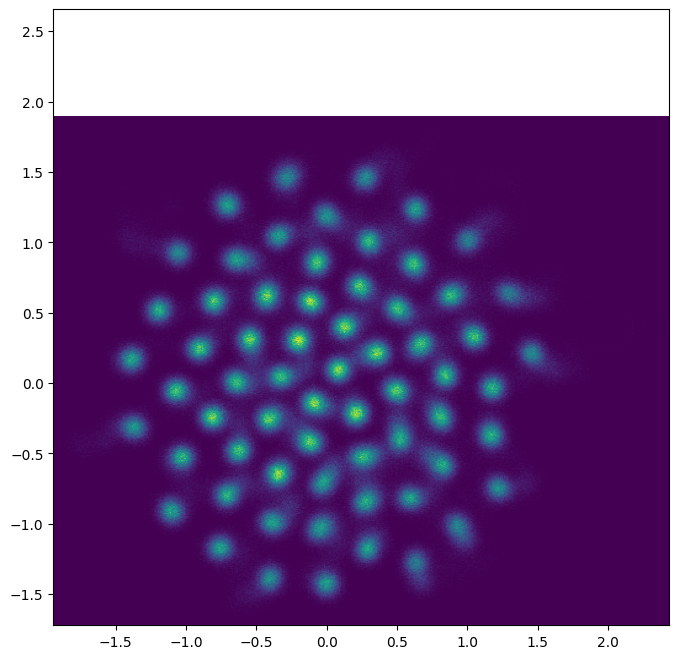

In [ ]:
all_y = np.reshape(np.stack(np_y),-1)
all_x = np.reshape(np.stack(np_x),-1)

noise = np.random.normal(0,1,size=all_x.shape)+1j*np.random.normal(0,1,size=all_x.shape)
all_x = all_x + 0.05*noise
heatmap, xedges, yedges = np.histogram2d(np.real(all_x), np.imag(all_x), bins=500)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.axis('square')